# CS 224, Winter 2021
## Problem Set 2

## Due February 7, 2021 @ 11:59pm PST


<div class="alert alert-info">
    <b>Complete with your Information</b><br>
    <i>By Submitting this notebook, I assert that all of the work presented here is my own and performed for the express sole purpose of this offering of this course.</i><br>
        <br>
      <b>(full) Name:</b>  Sakshar Chakravarty  <br>
    <b>Student ID Number:</b> 862253039
</div>

<div class="alert alert-success">
    <font size=+2>Total Problem Set Grading</font> (to be completed by grader)<br>
    Total Points: 23/24<br>
    Late Days Used on this assignment: 0<br>
    Total Late Days Used: 0<br>
</div>

### Preliminaries

We will again be using the data shown in class on house sales in Ames, Iowa.  Data documentation can be found at http://jse.amstat.org/v19n3/decock/DataDocumentation.txt

The code block below again loads in the data.  However, this time we will be using a one-hot encoding of the categorical features (see code comments). 

**Do NOT adjust** this code.  Further, you **may not add additional imports** to this notebook.

The resulting variables are slightly different than last time:
 - `trainX` & `trainY`: the training data, `trainX` has shape (number of homes, number of features) and `trainY` has shape (number of homes,).  We are trying to predict the y-values (home prices) from the x-values (other features of the homes for sale).
 - `testX` & `testY`: the testing data, in the same format at the training data.  We will use this as independent testing samples to see how well the training worked.
 - `featurenames`: an array (of strings) of each of the features'/columns' names
 - `nfeat`: total number of features/columns

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 100 # this and above will make the figures large enough to read
def loadamesdata(trainfrac = 0.5):
    import pandas as pd
    from IPython.display import display
    
    dataframe = pd.read_table('AmesHousing.txt',delimiter='\t')

    dataframe = dataframe[dataframe['Gr Liv Area']<4000] # remove the five really large houses
    dataframe = dataframe[dataframe['Sale Condition']=='Normal'] # don't consider partial sales or other types of abnormal sales
    dataframe = dataframe.drop(columns=['Order','PID','Sale Condition'])
    
    categoricalf = [col for col in dataframe if dataframe[col].dtype.name=='object' or col=='MS SubClass']
     # Here we are encoding the categorical variables using a "one-hot" encoding.  A variable with 3 values (A, B, C)
    # gets converted into three binary variables.  For any example (row) exactly one of these binary variables is 1
    # indicating which value the original categorical variable took on.
    dataframe = pd.get_dummies(dataframe,columns=categoricalf,prefix=categoricalf,dummy_na=True)
    # Here we are going to remove any item that is missing a value (encoded as NaN at this stage)
    # This is slightly problematic (it could be the missingness is actually related to the value or other features' values)
    # Filling it in (with say the average for that feature) is also problematic, in different ways
    # So for this problem set, we'll just remove listings (rows) that are missing any of their non-categorical features
    dataframe.dropna(inplace=True) # 
    
    dataframe = dataframe.loc[:,(dataframe!=dataframe.iloc[0]).any()] # drop features that have all the same value (across both training and testing)
    
    dataframe['SalePrice'] = dataframe['SalePrice']/1000 # convert to thousands of dollars, to prevent lots of extra 0s from needing to be printed
    dataframe = dataframe[[c for c in dataframe if c != 'SalePrice']+['SalePrice']]# rearrange to put SalePrice at the end:
    # training/testing split
    # can use "from sklearn.model_selection import train_test_split"
    # but to more directly show what is going on, here is a more "raw" version:
    allXY = dataframe.to_numpy()
    

    allXY = allXY[np.isfinite(allXY).all(axis=1),:]
    
    # in general, we would take a random shuffle.  However, to grade this consistently, I am going to fix the randomness of the shuffle
    np.random.seed(829281934) # my favorite number (well, out of the natural numbers) ;)
    np.random.shuffle(allXY) # randomly shuffles the *rows* of the input (or along whatever is the first dimension of the tensor)
    # we'll pick the first 50% (as default -- see "trainfrac" parameter as training and save the last 50% for testing
    lasttraini = int(allXY.shape[0]*trainfrac)
    trainXY = allXY[:lasttraini,:]
    testXY = allXY[lasttraini:,:]
    
    trainX = trainXY[:,:-1]
    trainY = trainXY[:,-1]
    testX = testXY[:,:-1]
    testY = testXY[:,-1]

    return trainX,trainY,testX,testY, dataframe.columns

trainX,trainY,testX,testY,featurenames = loadamesdata()
nfeat = trainX.shape[1]

## Problem Set Overview

This problem set explores linear regression, feature selection, PCA, and their interplay.  **PLEASE NOTE:** each section builds on the previous.  Therefore, you will want to turn the techniques in previous sections (once you've gotten them working) into nice modular functions so that you can use them later (like function to learn, calculate errors, select features, etc.).  **DO NOT** copy and paste code over and over.

## Question 1
### 4 points
<div class="alert alert-success">
    <font size=+1>Grading</font> (to be completed by grader)<br>
    Score: 4/4<br>
</div>

### Implement linear least squares regression 

Train on the training set and calculate the **mean squared error** on both the training set and the testing set.

**Report these two values.**

Notes:  
 - Calling `np.linalg.inv` or even `np.linalg.solve` on $XX^\top$ will not work, as the matrix is singular.  (You might want to contemplate why.)  Therefore, instead of calculating $(XX^\top)^{-1}X^\top$, calculate the *pseudo-inverse* of $X$ (with `np.linalg.pinv`).  This is defined even when $(XX^\top)$ is singular.  
 - You should estimate a constant/offset/bias term.  The easiest way to do this is to add a column of 1s to the data.  However, you shouldn't do this permanently (for instance, that column should not be part of the PCA analysis below).  Instead, just add it internally inside your functions when needed.

In [22]:
## Question 1
### YOUR CODE HERE (may split cell)
def addones(X, m):
    return np.hstack([np.ones((m, 1)), X])

def getWeight(X, Y):
    return (np.linalg.pinv(X.T@X)@X.T)@Y

def predict(X, W):
    return X@W

def getMSE(Y_, Y):
    diff = Y_ - Y
    return diff.T@diff

In [27]:
ntrainsamples = trainX.shape[0]
ntestsamples = testX.shape[0]
#print(ntrainsamples, ntestsamples)
temp_trainX = addones(trainX, ntrainsamples)
temp_testX = addones(testX, ntestsamples)
W = getWeight(temp_trainX, trainY)
predicted_trainY = predict(temp_trainX, W)
predicted_testY = predict(temp_testX, W)
#print(predicted_trainY.shape, predicted_testY.shape)
train_error = getMSE(predicted_trainY, trainY)
test_error = getMSE(predicted_testY, testY)
print("train error: ",train_error/ntrainsamples)
print("test error: ",test_error/ntestsamples)

train error:  173.80526561868643
test error:  562.5771469031582


## Question 2
#### 8 points

We will now explore using only some of the features.  **From here on** (ie to the end of the problem set), we will be plotting the training error and the testing error as a function of the number of features.  To make the plots comparable, please do the following **for all plots**

 - Set the horizontal range to be from 1 to the number of features
 - Set the vertical range to be from 0 to 2000 (even if the plot goes off the top)
 - The above two can be accmplished with a call to `plt.axis([1,nfeat,0,2000])`
 - Plot the training error first and the testing error second
 - Label each and add a legend (`plt.legend()`)
 - Plot the **mean** squared error as the error

### Question 2a
### 3 points
<div class="alert alert-success">
    <font size=+1>Grading</font> (to be completed by grader)<br>
    Score: 3/3<br>
</div>

First, we will try the features in the order in which they best predict the price (y) *individually*.  That is, for each feature, find the mean squared *training* error (using the testing error is cheating; you cannot select an aspect of your method using the testing data) as if that were the only feature (except the intercept/offset/bias term).  Order them from best-to-worst and plot the training and testing errors as a function of the number of features.  This means that if you are plotting it for 5 features, you use the 5 features that each individually best predict $y$.

In [82]:
## Question 2a
## YOUR CODE HERE (may split cell)
def ploterror(errors, tr_color='blue', ts_color='red'):
    plt.axis([1,nfeat,0,2000])
    x = np.arange(1,nfeat+1)
    plt.xlabel('# of features')
    plt.ylabel('error')
    plt.plot(x, errors[:,0], tr_color, label='training error')
    plt.plot(x, errors[:,1], ts_color, label='testing error')
    plt.legend(loc='upper right', shadow=True)
    plt.show()


In [85]:
trainerror_byfeat = []
for i in range(nfeat):
    temptraini_X = addones(trainX[:,i:i+1], ntrainsamples)
    Wi = getWeight(temptraini_X, trainY)
    predictedtraini_Y = predict(temptraini_X, Wi)
    trainerrori = getMSE(predictedtraini_Y, trainY)/ntrainsamples
    trainerror_byfeat.append((i, trainerrori))
trainerror_byfeat.sort(key=lambda x:x[-1])
errorsorted_feat = np.array(trainerror_byfeat, dtype=object)

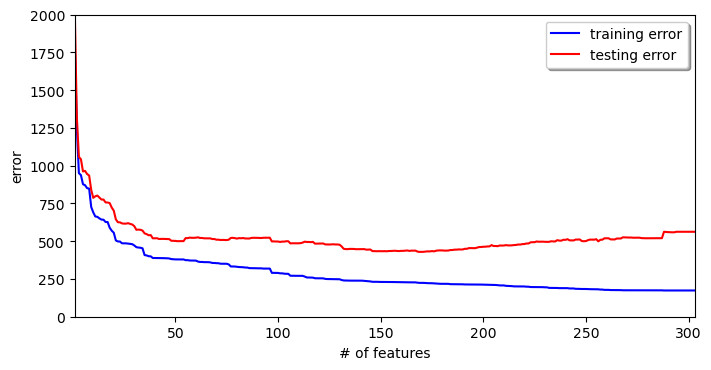

In [86]:
#print(errorsorted_feat[:5])
errors2a = np.zeros((nfeat, 2))
#print(errorsorted_feat[:10,0])
for i in range(nfeat):
    temp_trainX = addones(trainX[:,list(errorsorted_feat[:i+1,0])], ntrainsamples)
    temp_testX = addones(testX[:,list(errorsorted_feat[:i+1,0])], ntestsamples)
    W = getWeight(temp_trainX, trainY)
    predicted_trainY = predict(temp_trainX, W)
    predicted_testY = predict(temp_testX, W)
    train_error = getMSE(predicted_trainY, trainY)/ntrainsamples
    test_error = getMSE(predicted_testY, testY)/ntestsamples
    errors2a[i][0], errors2a[i][1] = train_error, test_error
ploterror(errors2a)

### Question 2b
### 2 points
<div class="alert alert-success">
    <font size=+1>Grading</font> (to be completed by grader)<br>
    Score: 2/2<br>
</div>

Why do these curve deviate, especially when the number of features is larger?  What does this mean about the optimal number of features?

### Question 2b
### MY ANSWER HERE
A set of features may produce less training error when the model is trained by them individually. However, it does not mean that combining features in the same non-decreasing order of trainig error will have less testing error too. From the curve of 2a, we can see that adding features gradually to the model, in the sorted order of individual trainig error, yielded lower training errors as well. But the testing error curve deviates from the training error curve after we added about 165 features. The probable explanation for the diminishing performance when the number of features is large can be that the model gets overfitted with irrelevant features. From this we can assume that the optimal number of features is near about 165.

### Question 2c
### 3 points
<div class="alert alert-success">
    <font size=+1>Grading</font> (to be completed by grader)<br>
    Score: 3/3<br>
</div>

Next, we will try adding the features in a greedy order.  That is, we will select the first feature, the same as in part a.  However, the second feature will be chosen to be the best *next* feature to add *given* that the first feature is fixed.  Then, fixing those two, we will find a third feature which, when added to the set, results in the smallest mean squared error on the training set.  We will so continue, building the feature set one at a time in this greedy manner, until all features have been added.

**Note:** This will take significantly longer than the previous method.  Mine took about 30 minutes to compute.

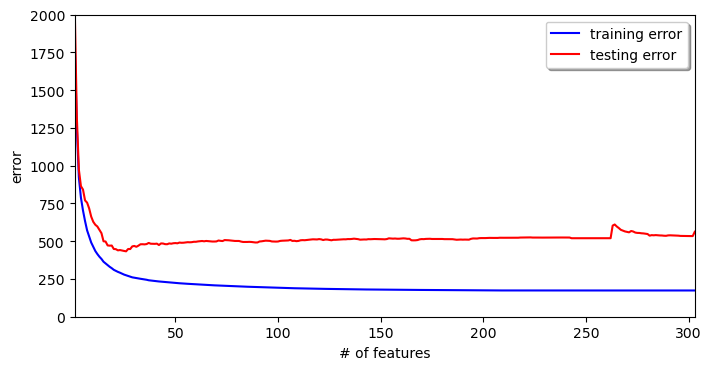

In [87]:
### Question 2c
### YOUR CODE HERE (may split cell)
errors2c = np.zeros((nfeat, 2))
#print(errorsorted_feat[:5,0])
feat_mask = np.ones((nfeat), dtype=bool)
ind = errorsorted_feat[0][0]
temp_trainX = addones(trainX[:,[ind]], ntrainsamples)
temp_testX = addones(testX[:,[ind]], ntestsamples)
W = getWeight(temp_trainX, trainY)
predicted_trainY = predict(temp_trainX, W)
predicted_testY = predict(temp_testX, W)
train_error = getMSE(predicted_trainY, trainY)/ntrainsamples
test_error = getMSE(predicted_testY, testY)/ntestsamples
errors2c[0][0], errors2c[0][1] = train_error, test_error
feat_mask[ind] = False
current_features = [ind]
for i in range(1,nfeat):
    current_error = np.inf
    current_W = None
    next_feat = -1
    for j in range(nfeat):
        if feat_mask[j]:
            current_features.append(j)
            temp_trainX = addones(trainX[:,current_features], ntrainsamples)
            W = getWeight(temp_trainX, trainY)
            predicted_trainY = predict(temp_trainX, W)
            train_error = getMSE(predicted_trainY, trainY)
            if train_error < current_error:
                current_error = train_error
                current_W = W
                next_feat = j
            current_features.remove(j)
    current_features.append(next_feat)
    temp_testX = addones(testX[:,current_features], ntestsamples)
    predicted_testY = predict(temp_testX, current_W)
    train_error = current_error/ntrainsamples
    test_error = getMSE(predicted_testY, testY)/ntestsamples
    feat_mask[next_feat] = False
    errors2c[i][0], errors2c[i][1] = train_error, test_error
ploterror(errors2c)

## Question 3
### 8 points

We will now do the same thing, but after transforming the data with PCA.  

### Question 3a
### 3 points
<div class="alert alert-success">
    <font size=+1>Grading</font> (to be completed by grader)<br>
    Score: 3/3<br>
</div>

Do a PCA transformation on the data, and now plot the training and testing errors as a function of the number of PCA components (features) used.  Order them from most-variance to least-variance.

Do not forget to subtract off the emperical mean.  (This mean should be calculated from the training set, but it is a form of a parameter and should be fixed and used for both the training and testing data.)

In [88]:
### Question 3a
### YOUR CODE HERE (may split cell)
def pca(X):
    C = np.cov(X, rowvar=False)
    evals, evecs = np.linalg.eig(C)
    idx = np.argsort(evals)[::-1]
    evecs = evecs[:,idx]
    evals = evals[idx]
    #projected_X = (evecs.T@X.T).T
    return evecs, evals

<ipython-input-89-292ef4e0b593>:18: ComplexWarning: Casting complex values to real discards the imaginary part
  errors3a[i][0], errors3a[i][1] = float(train_error), float(test_error)


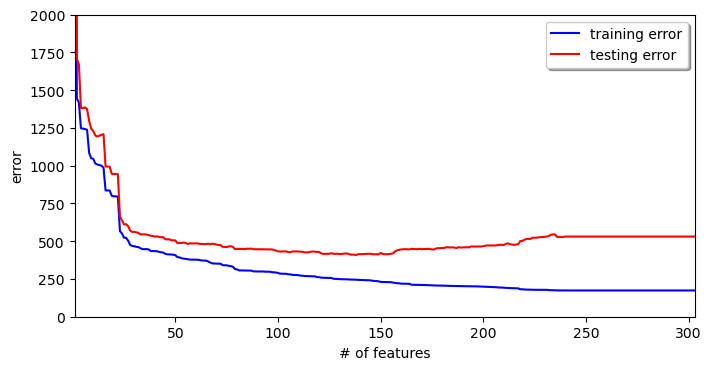

In [89]:
mean_feats = np.mean(trainX, axis=0)
#print(trainX[0][1], mean_feats[1])
centered_trainX = trainX - mean_feats
centered_testX = testX - mean_feats
evecs, evals = pca(centered_trainX)
errors3a = np.zeros((nfeat, 2))
for i in range(nfeat):
    cur_evecs = evecs[:,:i+1]
    projected_trainX = (cur_evecs.T@centered_trainX.T).T
    projected_testX = (cur_evecs.T@centered_testX.T).T
    temp_trainX = addones(projected_trainX, ntrainsamples)
    temp_testX = addones(projected_testX, ntestsamples)
    cur_W = getWeight(temp_trainX, trainY)
    predicted_trainY = predict(temp_trainX, cur_W)
    predicted_testY = predict(temp_testX, cur_W)
    train_error = getMSE(predicted_trainY, trainY)/ntrainsamples
    test_error = getMSE(predicted_testY, testY)/ntestsamples
    errors3a[i][0], errors3a[i][1] = float(train_error), float(test_error)
ploterror(errors3a)

### Question 3b
### 3 points
<div class="alert alert-success">
    <font size=+1>Grading</font> (to be completed by grader)<br>
    Score: 3/3<br>
</div>

PCA is sensitive to the scaling of the features.  If a feature just naturally has a larger scale, it will "matter more."  We can combat this by first scaling each feature (independently) by its standard deviation.  (This is the same as using the correlation matrix instead of the covariance matrix in PCA.)  This rescaling of each feature (usually after "centering" them) by its standard deviation goes by many names including "standardization," "z-score normalization," and "z-normalization."

That is, do the same as in part a, but now instead of just subtracting the mean from each feature, also divide each feature by its emperical standard deviation (again, from the training set).

<ipython-input-90-a69566be4cd2>:20: ComplexWarning: Casting complex values to real discards the imaginary part
  errors3b[i][0], errors3b[i][1] = float(train_error), float(test_error)


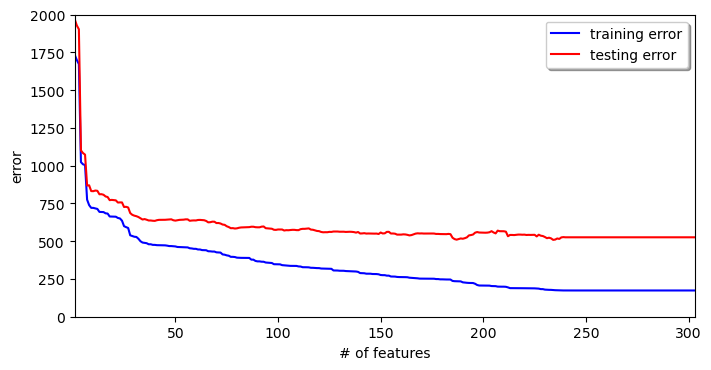

In [90]:
### Questino 3b
### YOUR CODE HERE (may split cell)
std_feats = np.std(trainX, axis=0)
std_feats[std_feats == 0] = 1
std_trainX = (trainX - mean_feats)/std_feats
std_testX = (testX - mean_feats)/std_feats
evecs, evals = pca(std_trainX)
errors3b = np.zeros((nfeat, 2))
for i in range(nfeat):
    cur_evecs = evecs[:,:i+1]
    projected_trainX = (cur_evecs.T@std_trainX.T).T
    projected_testX = (cur_evecs.T@std_testX.T).T
    temp_trainX = addones(projected_trainX, ntrainsamples)
    temp_testX = addones(projected_testX, ntestsamples)
    cur_W = getWeight(temp_trainX, trainY)
    predicted_trainY = predict(temp_trainX, cur_W)
    predicted_testY = predict(temp_testX, cur_W)
    train_error = getMSE(predicted_trainY, trainY)/ntrainsamples
    test_error = getMSE(predicted_testY, testY)/ntestsamples
    errors3b[i][0], errors3b[i][1] = float(train_error), float(test_error)
ploterror(errors3b)

### Question 3c
### 2 points
<div class="alert alert-success">
    <font size=+1>Grading</font> (to be completed by grader)<br>
    Score: 2/2<br>
</div>

Now use the same features from 3b above, but with the feature ordering strategy from part 2a (that is, order the new PCA features not by their variances, but by their predictive performance for $y$).  Plot the resulting training and testing error curves.

<ipython-input-91-5e81aaa2d14a>:26: ComplexWarning: Casting complex values to real discards the imaginary part
  errors3c[i][0], errors3c[i][1] = float(train_error), float(test_error)


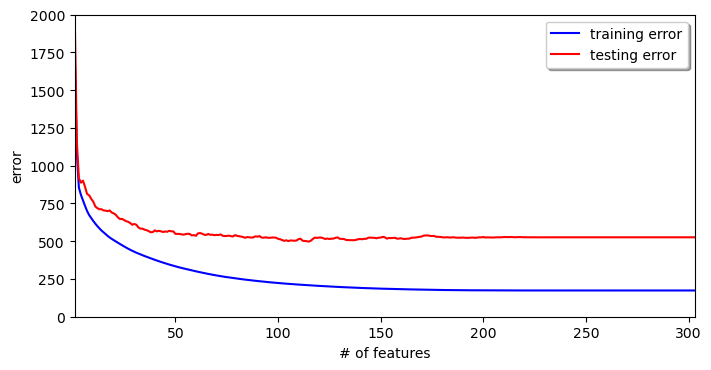

In [91]:
### Question 3c
### YOUR CODE HERE (may split cell)
trainerror_byfeature = np.zeros((nfeat,))
for i in range(nfeat):
    cur_evecs = evecs[:,i:i+1]
    projected_trainX = (cur_evecs.T@std_trainX.T).T
    temp_trainX = addones(projected_trainX, ntrainsamples)
    temp_W = getWeight(temp_trainX, trainY)
    predicted_trainY = predict(temp_trainX, temp_W)
    temp_error = getMSE(predicted_trainY, trainY)
    trainerror_byfeat[i] = temp_error
idx = np.argsort(trainerror_byfeat)
sorted_evecs = evecs[:, idx]
errors3c = np.zeros((nfeat, 2))
for i in range(nfeat):
    cur_evecs = sorted_evecs[:,:i+1]
    projected_trainX = (cur_evecs.T@std_trainX.T).T
    projected_testX = (cur_evecs.T@std_testX.T).T
    temp_trainX = addones(projected_trainX, ntrainsamples)
    temp_testX = addones(projected_testX, ntestsamples)
    cur_W = getWeight(temp_trainX, trainY)
    predicted_trainY = predict(temp_trainX, cur_W)
    predicted_testY = predict(temp_testX, cur_W)
    train_error = getMSE(predicted_trainY, trainY)/ntrainsamples
    test_error = getMSE(predicted_testY, testY)/ntestsamples
    errors3c[i][0], errors3c[i][1] = float(train_error), float(test_error)
ploterror(errors3c)

## Question 4
### 4 points

Bringing it together

### Question 4a
### 1 point
<div class="alert alert-success">
    <font size=+1>Grading</font> (to be completed by grader)<br>
    Score: 1/1<br>
</div>

Plot the results from parts 1a, 1c, 2a, 2c, and 2d together on the same plot.  

 - Don't recalculate them.  Have your functions from above save the plotted values to be used (again) here
 - Alternate training and testing (that is 1a-training, 1a-testing, 1c-training, 1c-testing, etc).  This way the "warm" colors will be testing and the "cool" colors training.  
 - Label the lines and use a legend

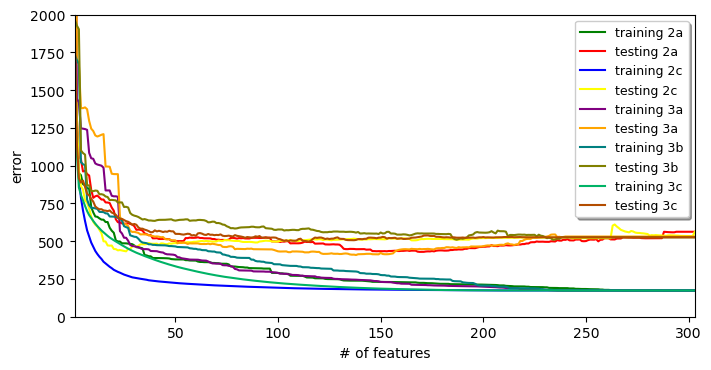

In [110]:
### Question 4a
### YOUR CODE HERE (may split cell)
plt.axis([1,nfeat,0,2000])
x = np.arange(1,nfeat+1)
plt.xlabel('# of features')
plt.ylabel('error')
plt.plot(x, errors2a[:,0], 'green', label='training 2a')
plt.plot(x, errors2a[:,1], 'red', label='testing 2a')
plt.plot(x, errors2c[:,0], 'blue', label='training 2c')
plt.plot(x, errors2c[:,1], 'yellow', label='testing 2c')
plt.plot(x, errors3a[:,0], 'purple', label='training 3a')
plt.plot(x, errors3a[:,1], 'orange', label='testing 3a')
plt.plot(x, errors3b[:,0], color=(0,0.5,0.5), label='training 3b')
plt.plot(x, errors3b[:,1], color=(0.5,0.5,0), label='testing 3b')
plt.plot(x, errors3c[:,0], color=(0,0.7,0.4), label='training 3c')
plt.plot(x, errors3c[:,1], color=(0.7,0.3,0), label='testing 3c')
plt.legend(loc='upper right', shadow=True, fontsize=9)
plt.show()

### Question 4b
### 3 points
<div class="alert alert-success">
    <font size=+1>Grading</font> (to be completed by grader)<br>
    Score: 2/3<br>
3c and 2c are not that similar.  *Testing* accuracy is what would matter, and the two are different -- all curves end at the same point.  Much of this description is just a repeat of what the method does.
</div>

Given the results above, if you were faced with a new problem, for which you *only* had training data (no testing data, although your method will later be evaluated on future testing data), and you needed to select a method for feature selection or dimensionality reduction,

Which method would you use?  *And why?*

### Question 4b
### MY ANSWER HERE
From the above curves, we can see that testing error curves of 2c and 3c are almost comparable. However, the testing error curve of 3c follows the trend of its training error the most. From this, I can assume that if faced with a new problem, I would go with the method in 3c. The reason for my choice is that here the data on which the model is trained is first centralized by subtracting the empreical mean of each of the features. This helps to remove any kind of noise. Then they were z-normalized with respect to the standard deviation. This helps to remove the dominance of any particular feature over the model. After that I will perform PCA on the modified data and project them along the eigen vectors. This helps to find out the top eigen vectors or top features similar to 2a in the modified data space and finally train the model on them which helps to generalize the model better and increases the chances of getting better performance on testing data.
Additionally, using 2c is not recommended as it is an exhaustive approach. If the number of features is large, it will take lots of time to train the model.